In [ ]:
from google.colab import drive
import torch

drive.mount('mount/')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

Mounted at mount/
cuda:0


```
# Uncomment the following block if running for the first time
```

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST
!rm -rf AudioMNIST/data/[1-5]*
!mkdir mount/MyDrive/audiomnist
!mv AudioMNIST/data/*/* mount/MyDrive/audiomnist

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.
mkdir: cannot create directory ‘mount/MyDrive/audiomnist’: File exists


In [ ]:
import os
import numpy as np
import csv

data_path = 'mount/MyDrive/audiomnist/'
label_path = 'mount/MyDrive/labels.csv'

data = [f for f in os.listdir(data_path)]
labels = []
for i in data:
  labels.append(i[0])

with open(label_path, 'w') as f:
  write = csv.writer(f)
  write.writerows(np.vstack((data,labels)).T)
f.close()

In [ ]:
print(data[0])

0_09_10.wav


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
from os import path
import torchaudio as ta

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 512
n_mfcc = 13

mfcc_transform = ta.transforms.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      # 'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    })

class AudioMNIST(Dataset):
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.labels = pd.read_csv(labels, header=None)
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = os.path.join(self.data, self.labels.iloc[idx, 0])
        wave, sr = ta.load(path, normalize=True)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            wave = ta.transforms.Resample(44100, 8000)(wave)
            wave = mfcc_transform(wave)
            wave = (wave-torch.mean(wave))/torch.std(wave)
            wave = torch.cat((wave, torch.zeros(1, n_mfcc, 17-wave.size(2))), dim=2)
        if self.target_transform:
            label = self.target_transform(label)
        return wave.T, label

audiomnist = AudioMNIST(label_path, data_path, True)

In [ ]:
import torch
import random
import torch.nn.functional as F

train, test = torch.utils.data.random_split(audiomnist, [4000, 1000], generator=torch.Generator().manual_seed(42))

torch.Size([17, 13, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


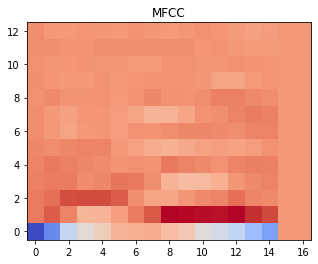

0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig, ax = plt.subplots()
print(audiomnist[0][0].size())
mfcc_data= np.swapaxes(audiomnist[0][0].squeeze(), 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')
plt.show()
print(audiomnist[0][1])

In [ ]:
!mkdir -p mount/MyDrive/audiomnist/train/wav
!mkdir -p mount/MyDrive/audiomnist/train/mask
!mkdir -p mount/MyDrive/audiomnist/test/wav
!mkdir -p mount/MyDrive/audiomnist/test/mask

In [ ]:
from tqdm import tqdm

for i, data in enumerate(tqdm(train)):
  torch.save(data[0], 'mount/MyDrive/audiomnist/train/wav/{}'.format(i))
  torch.save(data[1], 'mount/MyDrive/audiomnist/train/mask/{}'.format(i))

for i, data in enumerate(tqdm(test)):
  torch.save(data[0], 'mount/MyDrive/audiomnist/test/wav/{}'.format(i))
  torch.save(data[1], 'mount/MyDrive/audiomnist/test/mask/{}'.format(i))

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]
